## PurePursuit实现轨迹跟踪实现轨迹跟踪
参考[博客](https://blog.csdn.net/weixin_42301220/article/details/124882144?spm=1001.2014.3001.5501)

假设无人车模型如下

![在这里插入图片描述](https://img-blog.csdnimg.cn/98de36e913bd4fcd86b4f3ac933b0afc.png)

In [139]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib notebook
# %matplotlib qt5
# %matplotlib auto


In [140]:
import math
class KinematicModel_3:
  """假设控制量为转向角delta_f和加速度a
  """

  def __init__(self, x, y, psi, v, L, dt):
    self.x = x
    self.y = y
    self.psi = psi
    self.v = v
    self.L = L
    # 实现是离散的模型
    self.dt = dt

  def update_state(self, a, delta_f):
    self.x = self.x+self.v*math.cos(self.psi)*self.dt
    self.y = self.y+self.v*math.sin(self.psi)*self.dt
    self.psi = self.psi+self.v/self.L*math.tan(delta_f)*self.dt
    self.v = self.v+a*self.dt

  def get_state(self):
    return self.x, self.y, self.psi, self.v




参数设置

In [141]:
L=2 # 车辆轴距，单位：m
v = 2 # 初始速度
x_0=0 # 初始x
y_0=-3 #初始y
psi_0=0 # 初始航向角
dt=0.1 # 时间间隔，单位：s
lam = 0.1 # 前视距离系数
c=2 # 前视距离

搜索目标临近点

In [142]:
def cal_target_index(robot_state, refer_path,l_d):
    """得到前视目标点

    Args:
        robot_state (_type_): 当前车辆位置
        refer_path (_type_): 参考轨迹（数组）
        l_d：前视距离
    Returns:
        _type_: 前视目标点的索引
    """
    dists = []
    for xy in refer_path:
        dis = np.linalg.norm(robot_state-xy)
        dists.append(dis)

    min_index = np.argmin(dists)
    
    delta_l = np.linalg.norm(refer_path[min_index]-robot_state)
    # 搜索前视目标点
    while l_d > delta_l and (min_index+1) < len(refer_path):
        delta_l = np.linalg.norm(refer_path[min_index+1]-robot_state)
        min_index += 1
    return min_index


pure pursuit

In [143]:
def pure_pursuit_control(robot_state,current_ref_point,l_d):
    """pure pursuit

    Args:
        robot_state (_type_): 车辆位置
        current_ref_point (_type_): 当前参考路点
        l_d：前视距离
    return:返回前轮转向角delta
    """
    alpha = math.atan2(current_ref_point[1]-robot_state[1], current_ref_point[0]-robot_state[0])-ugv.psi
    delta = math.atan2(2*L*np.sin(alpha),l_d)
    return delta
    

主函数

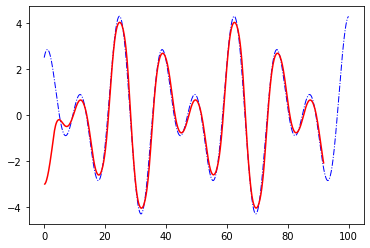

In [144]:


# set reference trajectory
refer_path = np.zeros((1000, 2))
refer_path[:,0] = np.linspace(0, 100, 1000) # 直线
refer_path[:,1] = 2*np.sin(refer_path[:,0]/3.0)+2.5*np.cos(refer_path[:,0]/2.0) # 生成正弦轨迹
plt.figure(1)
plt.plot(refer_path[:,0], refer_path[:,1], '-.b', linewidth=1.0)


ugv = KinematicModel_3(x_0,y_0,psi_0,v,L,dt)

x_ = []
y_ = []
for i in range(600):
    robot_state = np.zeros(2)
    robot_state[0] = ugv.x
    robot_state[1] = ugv.y
    
    l_d = lam*ugv.v+c # 注意，这里的运动学模型使用的速度v就是车身纵向速度vx
    ind = cal_target_index(robot_state,refer_path,l_d)  # 搜索前视路点


    delta = pure_pursuit_control(robot_state,refer_path[ind],l_d)

    ugv.update_state(0,delta) # 加速度设为0，恒速

    x_.append(ugv.x)
    y_.append(ugv.y)
plt.plot(x_,y_,'r')
plt.show()
